## Poisonous and Edible mushroom detection

In the Northeastern Region of Thailand there are five species of Mushrooms, which contain two species of poisonous mushrooms and three species of edible mushrooms.

Edible species : Amanita citrina, Russula delica
and Phaeogyroporus portentosus

Poisonous species : Amanita phalloides
and Inocybe rimosa



The data is taken from the following source:
Ketwongsa, W., Boonlue, S., & Kokaew, U. (2022, March 23). Poisonous and Edible Mushrooms
in the Northeastern Region of Thailand. Zenodo; Zenodo.
https://zenodo.org/record/6378474#.ZCLOsC-B1MQ

## Data Collection and Preprocessing: 

The image data obtained from the above data source is subject to feature selection, where resnet50 is selected as a base model for feature selection, for most of the classification models. Using this method extracts features in an efficient way which requires less further preprocessing, as mentioned in the efature extraction details of resnet50 model.

In [21]:
#%%
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from skimage import io
from tensorflow.keras.applications import resnet50
import matplotlib.pyplot as plt
import functools
import cv2
# load images
#%%
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from PIL import Image
import plotly.graph_objects as go
from tensorflow.python.keras.models import Sequential
from tensorflow.python.util import nest
os.getcwd()
#%%
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import reciprocal, uniform
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [17]:
#clean images
from google.colab import drive
drive.mount('/content/drive')
imgdir = r"/content/drive/MyDrive/Mushroom dataset1/Mushrooms"

def cleansource():
    delfiles = 0
    for sub in os.listdir(imgdir):
        for f in os.listdir(os.path.join(imgdir, sub)):
            filepath = os.path.join(imgdir, sub, f)
            notjpeg = False
            with open(filepath, "rb") as fh:
                fc = fh.read()
                if not tf.image.is_jpeg(fc):
                    notjpeg = True
                    delfiles = delfiles + 1
                try:
                    cv2.imread(filepath)
                except:
                    notjpeg = True
            if notjpeg:
                os.remove(filepath)

    print(f"{delfiles} files deleted.")

#cleansource()

#%%

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
path = '/content/drive/MyDrive/Mushroom dataset1/Mushrooms'

features = []
labels = []

for label in os.listdir(path):
    class_dir = os.path.join(path, label)

    for filename in os.listdir(class_dir):
        image_path = os.path.join(class_dir, filename)
        img = Image.open(image_path)

        img = img.resize((227, 227)).convert('L')

        img_data = np.array(img.getdata()).flatten()

        features.append(img_data)

        if label == 'Edible_mush':
            labels.append(0)
        elif label == 'Poisonous_mush':
            labels.append(1)

X = np.array(features)
y = np.array(labels)

print("Shape of X (features):", X.shape)
print("Shape of y (labels):", y.shape)


scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)

X_pca = pca.fit_transform(X_scaled)


Shape of X (features): (1970, 51529)
Shape of y (labels): (1970,)


#### Visualization of the image classification

In [20]:
# Scatter plot showing distinction between edible and poisonous mushrooms

fig = go.Figure(data=go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='markers',
    marker=dict(
        color=y, 
        colorscale=[[0, 'green'], [1, 'red']], 
        size=1
    ),
    showlegend=True, 
))

fig.update_layout(
    scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'),
    title='Scatter3D Plot'
)

fig.show()


In the above figure green dots represent edible mushrroms while red dots represent poisonous mushrooms.

In [24]:
def get_image_data(subset):
    return keras.utils.image_dataset_from_directory(r"/content/drive/MyDrive/Mushroom dataset1/Mushrooms", 
                    labels="inferred",
                    image_size=(227,227),
                    batch_size=8,
                    seed=0,
                    subset=subset,
                    validation_split=0.25,
                    crop_to_aspect_ratio=True)

df_train = get_image_data("training")
df_val = get_image_data("validation")

def preprocess(img, label):
    img = resnet50.preprocess_input(img)
    return img, label

df_train = df_train.map(preprocess).map(lambda x, y: (tf.reshape(x, (tf.shape(x)[0], -1)), y))
df_val = df_val.map(preprocess).map(lambda x, y: (tf.reshape(x, (tf.shape(x)[0], -1)), y))

X_train = np.vstack([x.numpy() for x, _ in df_train])
y_train = np.hstack([y.numpy() for _, y in df_train])
X_val = np.vstack([x.numpy() for x, _ in df_val])
y_val = np.hstack([y.numpy() for _, y in df_val])

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

Found 1970 files belonging to 2 classes.
Using 1478 files for training.
Found 1970 files belonging to 2 classes.
Using 492 files for validation.


In [25]:
# Create a PCA object with the desired number of components
pca = PCA(n_components=3)

X_train = pca.fit_transform(X_train)

print("Explained variance ratio:", sum(pca.explained_variance_ratio_))

X_val = pca.transform(X_val)

Explained variance ratio: 0.7649160176515579


#### RandomForestClassifier

In [ ]:
# Define the parameter grid

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier()


random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5, 
    scoring='accuracy', 
    random_state=42
)


random_search.fit(X_train, y_train) 

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters : ", best_params)
print("Best score : ", best_score)

Best parameters :  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Best score :  0.7334264773247824


#### SVM Classifier

In [ ]:
param_dist = {
    'C': reciprocal(0.1, 10),
    'gamma': reciprocal(0.01, 1),
    'kernel': ['linear', 'rbf']
}

svc_model = SVC()
random_search = RandomizedSearchCV(estimator=svc_model, param_distributions=param_dist, cv=3, scoring='accuracy', n_iter=10, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

print(best_params)
y_pred = best_model.predict(X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

{'C': 0.5611516415334504, 'gamma': 0.7969454818643928, 'kernel': 'linear'}
Validation Accuracy: 0.7520325203252033


#### KNeighborsClassifier

In [ ]:
param_dist = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, cv=3, scoring='accuracy', n_iter=10, random_state=42)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_
y_pred_train = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training accuracy:", train_accuracy)

y_pred_val = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation accuracy:", val_accuracy)


Training accuracy: 0.7415426251691475
Validation accuracy: 0.7378048780487805


#### VGG16

In [ ]:
image_dir = "/content/drive/MyDrive/Mushroom dataset/cnn"
input_shape = (227, 227, 3)
batch_size = 32
epochs = 10
validation_split = 0.2

# Create an ImageDataGenerator for data preprocessing and augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=validation_split
)

# Generate training and validation data from the image directory as the feature extraction is different for different models of keras applications
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the VGG16 model (pre-trained on ImageNet) without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))


Found 1633 images belonging to 2 classes.
Found 407 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
51/51 [==============================] - 1297s 25s/step - loss: 0.1187 - accuracy: 0.9582 - val_loss: 0.1926 - val_accuracy: 0.9375
Epoch 2/10
51/51 [==============================] - 1266s 25s/step - loss: 0.0742 - accuracy: 0.9738 - val_loss: 0.3890 - val_accuracy: 0.9115
Epoch 3/10
51/51 [==============================] - 1284s 25s/step - loss: 0.0184 - accuracy: 0.9913 - val_loss: 0.1414 - val_accuracy: 0.9531
Epoch 4/10
51/51 [==============================] - 1267s 25s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1241 - val_accuracy: 0.9479
Epoch 5/10
51/51 [==============================] - 1259s 25s/step - loss: 9.6497e-04 - accuracy: 1.0000 - val_loss: 0.1024 - val_accuracy: 0.9583
Epoch 6/10
51/51 [==============================] - 1250s 25s/step - loss: 7.4331e-04 - accuracy: 1.0000 - val_loss: 0.0881 - val_acc

#### MobileNetV2

In [ ]:

image_dir = "/content/drive/MyDrive/Mushroom dataset/cnn"
input_size = (227, 227)
batch_size = 32
num_classes = 2
random_seed = 42

train_ratio = 0.8
val_ratio = 0.2
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_ratio
)

# Generate training and validation data from the image directory as the feature extraction is different for different models of keras applications
train_data = datagen.flow_from_directory(
    image_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=random_seed
)

val_data = datagen.flow_from_directory(
    image_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=random_seed
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(input_size[0], input_size[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // batch_size,
    epochs=8
)
loss, accuracy = model.evaluate(val_data, steps=val_data.samples // batch_size)


Found 1633 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


Epoch 1/8
51/51 [==============================] - 423s 8s/step - loss: 0.1895 - accuracy: 0.9325 - val_loss: 1.2531 - val_accuracy: 0.4922
Epoch 2/8
51/51 [==============================] - 406s 8s/step - loss: 0.0668 - accuracy: 0.9819 - val_loss: 0.8252 - val_accuracy: 0.5859
Epoch 3/8
51/51 [==============================] - 402s 8s/step - loss: 0.0259 - accuracy: 0.9925 - val_loss: 5.0374 - val_accuracy: 0.3724
Epoch 4/8
51/51 [==============================] - 403s 8s/step - loss: 0.0892 - accuracy: 0.9738 - val_loss: 1.8513 - val_accuracy: 0.5104
Epoch 5/8
51/51 [==============================] - 405s 8s/step - loss: 0.0487 - accuracy: 0.9881 - val_loss: 8.3898 - val_accuracy: 0.3464
Epoch 6/8
51/51 [==============================] - 406s 8s/step - loss: 0.0140 - accuracy: 0.9956 - val_loss: 1.6454 - val_accuracy: 0.7500
Epoch 7/8
51/51 [==============================] - 404s 8s/step - loss: 0.1107 - accuracy: 0.9681 - val_loss: 55.3095 - val_accuracy: 0.2604
Epoch 8/8
51/51 [==

#### Resnet50

In [26]:

def get_image_data(subset):
    return keras.utils.image_dataset_from_directory(r"/content/drive/MyDrive/Mushroom dataset1/Mushrooms", 
                    labels="inferred",
                    image_size=(227,227),
                    batch_size=8,
                    seed=0,
                    subset=subset,
                    validation_split=0.25,
                    crop_to_aspect_ratio=True)

df_train = get_image_data("training")
df_val = get_image_data("validation")
#%%

res_model = resnet50.ResNet50(include_top=False)
top_layer = keras.layers.GlobalAveragePooling2D()(res_model.output)
top_layer = keras.layers.Flatten()(top_layer)
top_layer = keras.layers.Dense(2, activation='softmax')(top_layer)
model = keras.models.Model(res_model.input, top_layer)

# %%
model.compile(
    "adamax",
    "sparse_categorical_crossentropy", metrics=["accuracy"])
# %%
def preprocess(img, label):
    img = resnet50.preprocess_input(img)
    return img, label
df_train = df_train.map(preprocess)
df_val = df_val.map(preprocess)

# %%
model.fit(df_train, validation_data=df_val, epochs=5)

Found 1970 files belonging to 2 classes.
Using 1478 files for training.
Found 1970 files belonging to 2 classes.
Using 492 files for validation.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/5
185/185 [==============================] - 1783s 10s/step - loss: 0.3104 - accuracy: 0.8992 - val_loss: 0.6067 - val_accuracy: 0.9024
Epoch 2/5
185/185 [==============================] - 1458s 8s/step - loss: 0.0806 - accuracy: 0.9723 - val_loss: 0.0460 - val_accuracy: 0.9817
Epoch 3/5
185/185 [==============================] - 1445s 8s/step - loss: 0.0346 - accuracy: 0.9858 - val_loss: 0.0188 - val_accuracy: 0.9939
Epoch 4/5
185/185 [==============================] - 1444s 8s/step - loss: 0.0302 - accuracy: 0.9899 - val_loss: 0.0412 - val_accuracy: 0.9837
Epoch 5/5
185/185 [==============================] - 1390s 8s/step - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.0350 - val_accuracy: 0.9858


The Resnet50 model is selected due to it's high validation accuracy among all the other models that we have trained. The model is saved to further use on test data.

In [28]:
model.save("mushrooms.h5")

## Evaluation and Results

In [29]:
# load test images
#%%
df = keras.utils.image_dataset_from_directory(r"/content/drive/MyDrive/Mushroom dataset1/test", 
                    labels="inferred",
                    image_size=(227,227),
                    batch_size=128,
                    seed=0,
                    crop_to_aspect_ratio=True)

#%%

model = keras.models.load_model("mushrooms.h5")

#%%
def preprocess(img, label):
    return resnet50.preprocess_input(img), label
df = df.map(preprocess)
dfu = [(x[0], x[1]) for x in df.unbatch()]
X = np.array([x[0] for x in dfu])
y = np.array([x[1] for x in dfu])


# %%
y_pred = model.predict(X, verbose=1)
print(np.argmax(y_pred, axis=1))
print(y)


model.evaluate(df)

Found 30 files belonging to 2 classes.
1/1 [==============================] - 10s 10s/step
[0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1]
[0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1]
1/1 [==============================] - 10s 10s/step - loss: 0.1907 - accuracy: 0.9667


[0.19069364666938782, 0.9666666388511658]

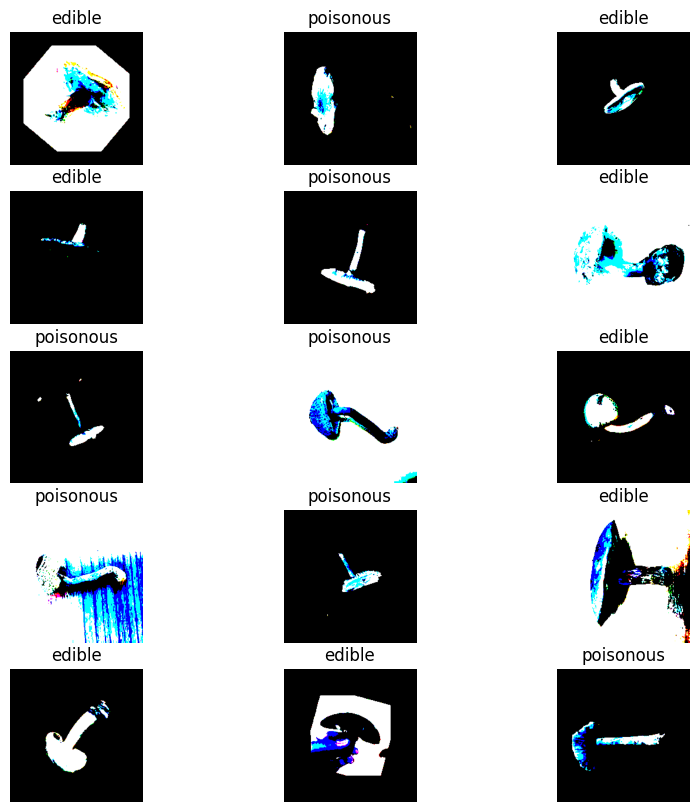

In [30]:
fig, axs = plt.subplots(5,3, figsize=(10,10))
axs = np.array(axs).ravel()
labels=["edible", "poisonous"]
for ax, x, yp, yt in zip(axs, X, y_pred, y):
    ax.imshow(x)
    ax.set_axis_off()
    ax.set_title(labels[yt])

1/1 [==============================] - 1s 1s/step


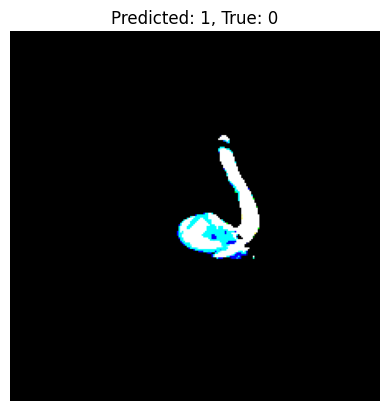

1/1 [==============================] - 1s 1s/step


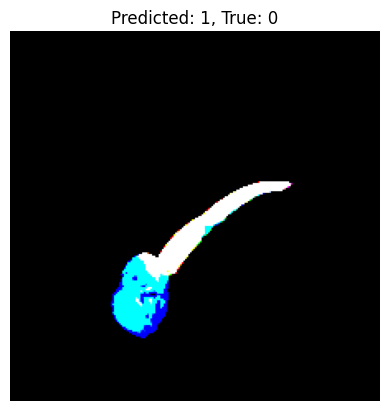

1/1 [==============================] - 2s 2s/step


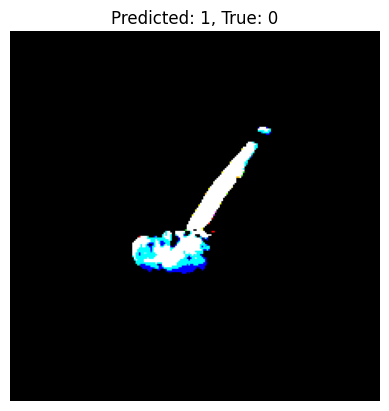

1/1 [==============================] - 1s 1s/step


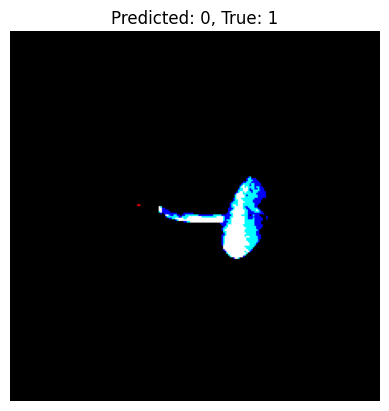

1/1 [==============================] - 1s 684ms/step


In [15]:
# Displaying the images which were wrongly identified

for img, label in df_val:
    predictions = model.predict(img)
    predicted_label = np.argmax(predictions, axis=1)
    for i in range(img.shape[0]):
        img_single = img[i]
        label_single = label[i]
        if predicted_label[i] != label_single:
            plt.imshow(img_single)
            plt.title(f"Predicted: {predicted_label[i]}, True: {label_single}")
            plt.axis("off")
            plt.show()


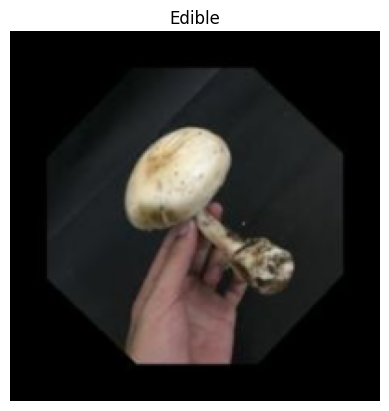

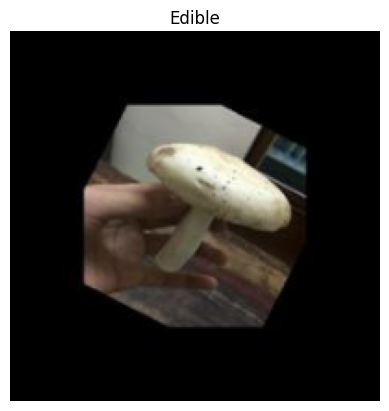

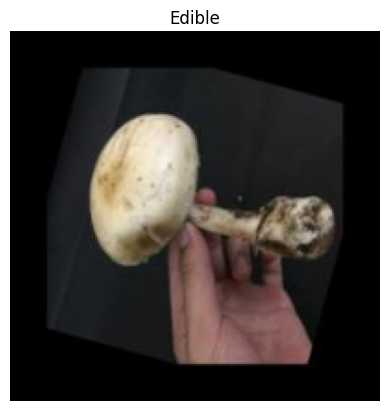

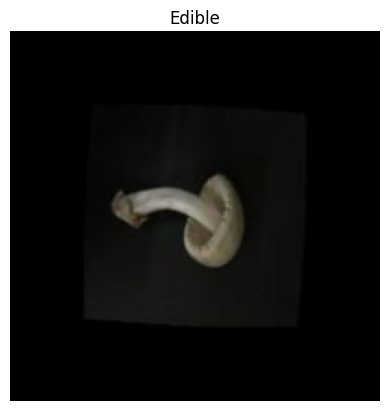

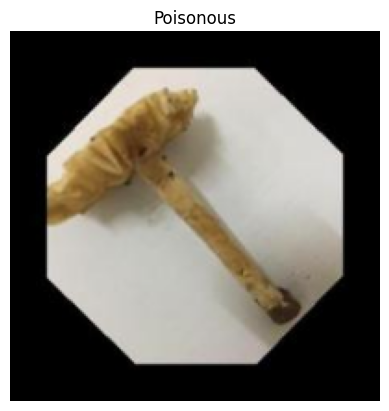

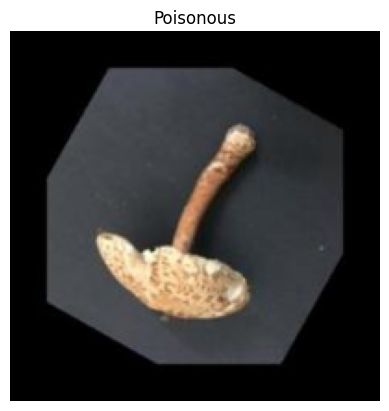

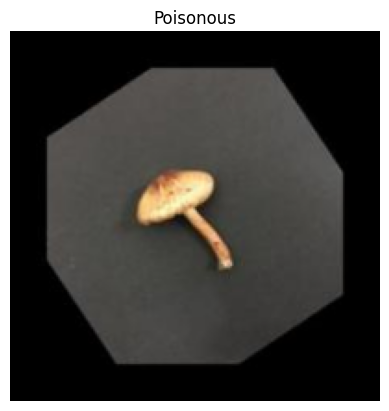

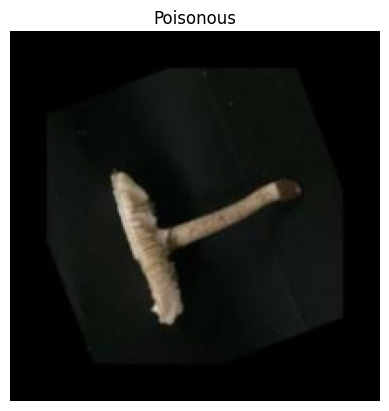

In [10]:
# Displaying the actual images of some poisonous and edible mushrooms

image_dir = "/content/drive/MyDrive/Mushroom dataset/cnn"
class_names = ["Edible", "Poisonous"]
image_size = (200, 200)

for class_name in class_names:
    class_dir = os.path.join(image_dir, class_name)
    image_files = os.listdir(class_dir)[:4]
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        image = cv2.imread(image_path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis("off")
        plt.show()

## Conclusion

Obtaining more images could have better prospects for different classification model with better precision. Mushrooms can be classified into edible and poisonous with the obtained model with a validation accuracy of 0.98